In [1]:
# ! pip install modAL


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime
from helper_functions import multilabel_evaluation

from modAL.models import ActiveLearner,Committee
from modAL.uncertainty import uncertainty_sampling, margin_sampling,entropy_sampling

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
# import tweet processing module
from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()

# import train and test data
emo_train_df = pd.read_csv('data/2018-E-c-En-train.txt', sep='\t')
emo_test_df = pd.read_csv('data/2018-E-c-En-test-gold.txt', sep='\t')
emo_train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [4]:
feelings = emo_train_df.columns[2:]#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
feelings

Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism',
       'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [5]:
# combine and preprocess test and training sets
combined_df = pd.concat([emo_train_df, emo_test_df])

# Tweet preprocessing
combined_df['tokenized_features'] = combined_df['Tweet'].apply(tweet_processor.tweet_pipeline)
X = combined_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)
# Merge features in a single feature vector
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))

# Split in train and test set
emo_train_df['feature_vector'] = X_combined[:emo_train_df.shape[0]].tolist()
emo_test_df['feature_vector'] = X_combined[-emo_test_df.shape[0]:].tolist()
emo_train_df['feature_vector'].shape, emo_test_df['feature_vector'].shape

x_train = np.vstack(emo_train_df['feature_vector'].values)
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = emo_train_df[feelings].values
y_test = emo_test_df[feelings].values

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6838, 4824), (6838, 11), (3259, 4824), (3259, 11))

In [6]:
# Split in actual train and holdout set
x_train_actual, x_holdout, y_train_actual, y_holdout = train_test_split(x_train, y_train, test_size=0.9, random_state=42)

print(x_train_actual.shape, y_train_actual.shape, x_holdout.shape, y_holdout.shape)


learner = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy= margin_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 

# Record our learner's score on the raw data.
y_pred = learner.predict(x_test)

starting_res = multilabel_evaluation(y_pred, y_test)
print(starting_res)

accuracy_res = [starting_res["accuracy"]]
precision_res = [starting_res["precision"]]
recall_res = [starting_res["recall"]]
f1_res = [starting_res["f1_score"]]
hamming_loss_res = [starting_res["hamming_loss"]]

print("")
print("Starting Active Learning...")
print("")
start = datetime.now()

N_QUERIES = 1000
for index in range(N_QUERIES):
   query_index, query_instance = learner.query(x_holdout)
   # Teach our ActiveLearner model the record it has requested.
   X, y = x_holdout[query_index].reshape(1, -1), y_holdout[query_index].reshape(1, -1)
   learner.teach(X=X, y=y)
   
   # Remove the queried instance from the unlabeled pool.
   x_holdout, y_holdout = np.delete(x_holdout, query_index, axis=0), np.delete(y_holdout, query_index, axis=0)
   
   print(index)
   if(index % 100) == 0:      
      prediction = learner.predict(x_test)
      results = multilabel_evaluation(prediction, y_test)
      print(results)
    
      accuracy_res.append(results["accuracy"])
      precision_res.append(results["precision"])
      recall_res.append(results["recall"])
      f1_res.append(results["f1_score"])
      hamming_loss_res.append(results["hamming_loss"])

        
prediction = learner.predict(x_test)
results = multilabel_evaluation(prediction, y_test)
print(results)
    
accuracy_res.append(results["accuracy"])
precision_res.append(results["precision"])
recall_res.append(results["recall"])
f1_res.append(results["f1_score"])
hamming_loss_res.append(results["hamming_loss"])      
            
print('Finished active learning in : ', datetime.now()-start) 


(683, 4824) (683, 11) (6155, 4824) (6155, 11)
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.487, 'f1_score': 0.069, 'hamming_loss': 0.208}

Starting Active Learning...

0
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.488, 'f1_score': 0.069, 'hamming_loss': 0.208}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
{'accuracy': 0.794, 'precision': 0.047, 'recall': 0.468, 'f1_score': 0.085, 'hamming_loss': 0.206}
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
1

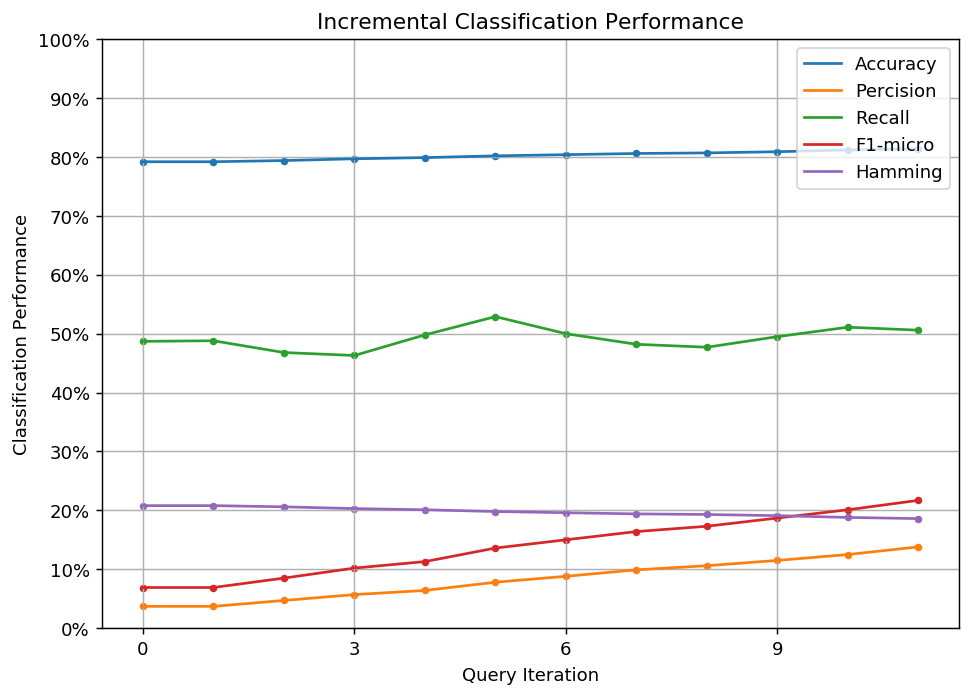

In [7]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(accuracy_res)
ax.plot(precision_res)
ax.plot(recall_res)
ax.plot(f1_res)
ax.plot(hamming_loss_res)
ax.scatter(range(len(accuracy_res)), accuracy_res, s=10)
ax.scatter(range(len(precision_res)), precision_res, s=10)
ax.scatter(range(len(recall_res)), recall_res, s=10)
ax.scatter(range(len(f1_res)), f1_res, s=10)
ax.scatter(range(len(hamming_loss_res)), hamming_loss_res, s=10)
ax.legend(['Accuracy','Percision','Recall','F1-micro','Hamming'])


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental Classification Performance')
ax.set_xlabel('Query Iteration')
ax.set_ylabel('Classification Performance')

plt.show()

In [8]:
# Split in actual train and holdout set
x_train_actual, x_holdout, y_train_actual, y_holdout = train_test_split(x_train, y_train, test_size=0.9, random_state=42)

print(x_train_actual.shape, y_train_actual.shape, x_holdout.shape, y_holdout.shape)


learner = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy= uncertainty_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 

# Record our learner's score on the raw data.
y_pred = learner.predict(x_test)

starting_res = multilabel_evaluation(y_pred, y_test)
print(starting_res)

accuracy_res_U = [starting_res["accuracy"]]
precision_res_U = [starting_res["precision"]]
recall_res_U = [starting_res["recall"]]
f1_res_U = [starting_res["f1_score"]]
hamming_loss_res_U = [starting_res["hamming_loss"]]

print("")
print("Starting Active Learning...")
print("")
start = datetime.now()

N_QUERIES = 1000
for index in range(N_QUERIES):
   query_index, query_instance = learner.query(x_holdout)
   # Teach our ActiveLearner model the record it has requested.
   X, y = x_holdout[query_index].reshape(1, -1), y_holdout[query_index].reshape(1, -1)
   learner.teach(X=X, y=y)
   
   # Remove the queried instance from the unlabeled pool.
   x_holdout, y_holdout = np.delete(x_holdout, query_index, axis=0), np.delete(y_holdout, query_index, axis=0)
   
   print(index)
   if(index % 100) == 0:      
      prediction = learner.predict(x_test)
      results = multilabel_evaluation(prediction, y_test)
      print(results)
    
      accuracy_res_U.append(results["accuracy"])
      precision_res_U.append(results["precision"])
      recall_res_U.append(results["recall"])
      f1_res_U.append(results["f1_score"])
      hamming_loss_res_U.append(results["hamming_loss"])

        
prediction = learner.predict(x_test)
results = multilabel_evaluation(prediction, y_test)
print(results)
    
accuracy_res_U.append(results["accuracy"])
precision_res_U.append(results["precision"])
recall_res_U.append(results["recall"])
f1_res_U.append(results["f1_score"])
hamming_loss_res_U.append(results["hamming_loss"])      
            
print('Finished active learning in : ', datetime.now()-start) 

(683, 4824) (683, 11) (6155, 4824) (6155, 11)
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.487, 'f1_score': 0.069, 'hamming_loss': 0.208}

Starting Active Learning...

0
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.487, 'f1_score': 0.069, 'hamming_loss': 0.208}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
{'accuracy': 0.791, 'precision': 0.035, 'recall': 0.477, 'f1_score': 0.065, 'hamming_loss': 0.209}
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
1

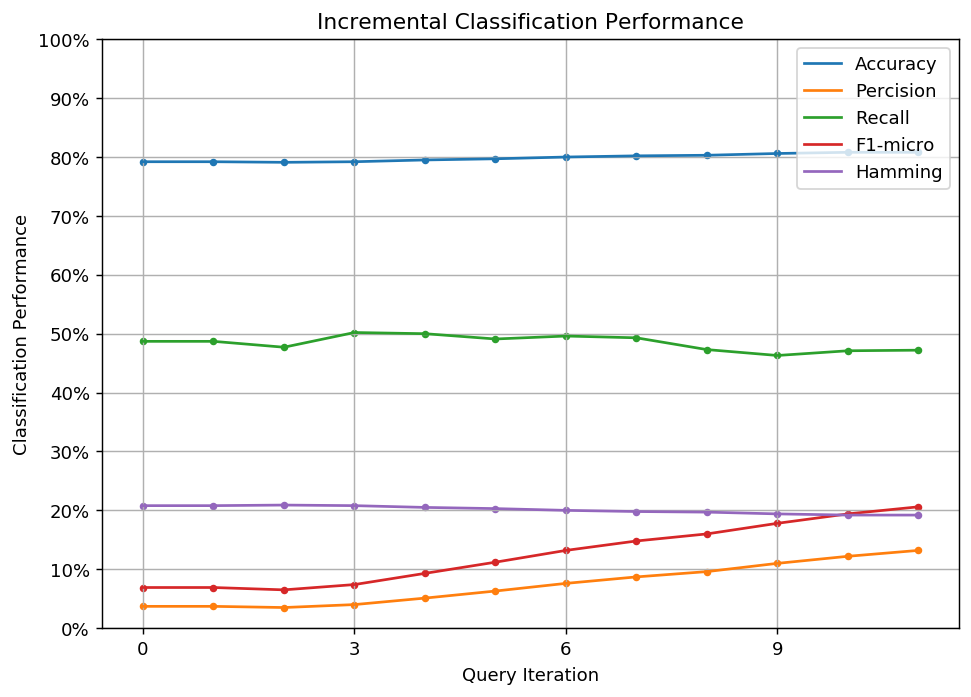

In [9]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(accuracy_res_U)
ax.plot(precision_res_U)
ax.plot(recall_res_U)
ax.plot(f1_res_U)
ax.plot(hamming_loss_res_U)
ax.scatter(range(len(accuracy_res_U)), accuracy_res_U, s=10)
ax.scatter(range(len(precision_res_U)), precision_res_U, s=10)
ax.scatter(range(len(recall_res_U)), recall_res_U, s=10)
ax.scatter(range(len(f1_res_U)), f1_res_U, s=10)
ax.scatter(range(len(hamming_loss_res_U)), hamming_loss_res_U, s=10)
ax.legend(['Accuracy','Percision','Recall','F1-micro','Hamming'])


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental Classification Performance')
ax.set_xlabel('Query Iteration')
ax.set_ylabel('Classification Performance')

plt.show()

In [10]:
# Split in actual train and holdout set
x_train_actual, x_holdout, y_train_actual, y_holdout = train_test_split(x_train, y_train, test_size=0.9, random_state=42)

print(x_train_actual.shape, y_train_actual.shape, x_holdout.shape, y_holdout.shape)


learner = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy= entropy_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 

# Record our learner's score on the raw data.
y_pred = learner.predict(x_test)

starting_res = multilabel_evaluation(y_pred, y_test)
print(starting_res)

accuracy_res_E = [starting_res["accuracy"]]
precision_res_E = [starting_res["precision"]]
recall_res_E = [starting_res["recall"]]
f1_res_E = [starting_res["f1_score"]]
hamming_loss_res_E = [starting_res["hamming_loss"]]

print("")
print("Starting Active Learning...")
print("")
start = datetime.now()

N_QUERIES = 1000
for index in range(N_QUERIES):
   query_index, query_instance = learner.query(x_holdout)
   # Teach our ActiveLearner model the record it has requested.
   X, y = x_holdout[query_index].reshape(1, -1), y_holdout[query_index].reshape(1, -1)
   learner.teach(X=X, y=y)
   
   # Remove the queried instance from the unlabeled pool.
   x_holdout, y_holdout = np.delete(x_holdout, query_index, axis=0), np.delete(y_holdout, query_index, axis=0)
   
   print(index)
   if(index % 100) == 0:      
      prediction = learner.predict(x_test)
      results = multilabel_evaluation(prediction, y_test)
      print(results)
    
      accuracy_res_E.append(results["accuracy"])
      precision_res_E.append(results["precision"])
      recall_res_E.append(results["recall"])
      f1_res_E.append(results["f1_score"])
      hamming_loss_res_E.append(results["hamming_loss"])

        
prediction = learner.predict(x_test)
results = multilabel_evaluation(prediction, y_test)
print(results)
    
accuracy_res_E.append(results["accuracy"])
precision_res_E.append(results["precision"])
recall_res_E.append(results["recall"])
f1_res_E.append(results["f1_score"])
hamming_loss_res_E.append(results["hamming_loss"])      
            
print('Finished active learning in : ', datetime.now()-start) 

(683, 4824) (683, 11) (6155, 4824) (6155, 11)
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.487, 'f1_score': 0.069, 'hamming_loss': 0.208}

Starting Active Learning...

0
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.396, 'f1_score': 0.068, 'hamming_loss': 0.208}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
{'accuracy': 0.794, 'precision': 0.044, 'recall': 0.48, 'f1_score': 0.081, 'hamming_loss': 0.206}
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
18

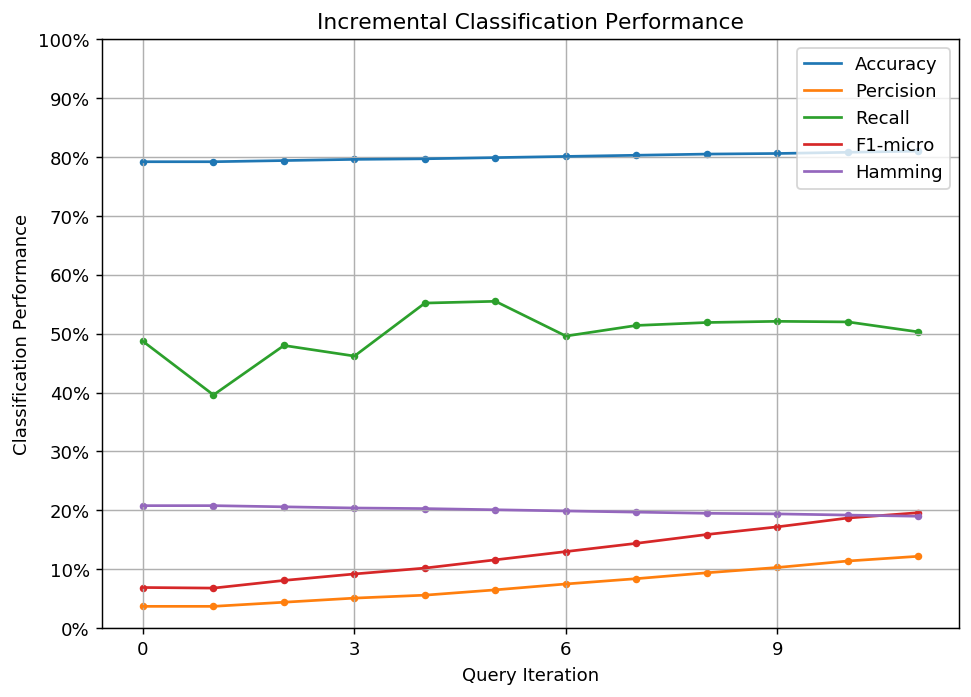

In [11]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(accuracy_res_E)
ax.plot(precision_res_E)
ax.plot(recall_res_E)
ax.plot(f1_res_E)
ax.plot(hamming_loss_res_E)
ax.scatter(range(len(accuracy_res_E)), accuracy_res_E, s=10)
ax.scatter(range(len(precision_res_E)), precision_res_E, s=10)
ax.scatter(range(len(recall_res_E)), recall_res_E, s=10)
ax.scatter(range(len(f1_res_E)), f1_res_E, s=10)
ax.scatter(range(len(hamming_loss_res_E)), hamming_loss_res_E, s=10)
ax.legend(['Accuracy','Percision','Recall','F1-micro','Hamming'])


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental Classification Performance')
ax.set_xlabel('Query Iteration')
ax.set_ylabel('Classification Performance')

plt.show()

In [12]:
# Split in actual train and holdout set
x_train_actual, x_holdout, y_train_actual, y_holdout = train_test_split(x_train, y_train, test_size=0.9, random_state=42)

print(x_train_actual.shape, y_train_actual.shape, x_holdout.shape, y_holdout.shape)


learner_R = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy=uncertainty_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 

# Record our learner's score on the raw data.
y_pred = learner_R.predict(x_test)

starting_res_R = multilabel_evaluation(y_pred, y_test)
print(starting_res_R)

accuracy_res_R = [starting_res_R["accuracy"]]
precision_res_R = [starting_res_R["precision"]]
recall_res_R = [starting_res_R["recall"]]
f1_res_R = [starting_res_R["f1_score"]]
hamming_loss_res_R = [starting_res_R["hamming_loss"]]

print("")
print("Starting Active Learning...")
print("")
start = datetime.now()

N_QUERIES = 1000
for index in range(N_QUERIES):
   query_index =  random.randint(0, x_holdout.shape[0]-1)
   # Teach our ActiveLearner model the record it has requested.
   X, y = x_holdout[query_index].reshape(1, -1), y_holdout[query_index].reshape(1, -1)
   learner_R.teach(X=X, y=y)
   
   # Remove the queried instance from the unlabeled pool.
   x_holdout, y_holdout = np.delete(x_holdout, query_index, axis=0), np.delete(y_holdout, query_index, axis=0)
   
   print(index)
   if(index % 100) == 0:      
      prediction = learner_R.predict(x_test)
      results = multilabel_evaluation(prediction, y_test)
      print(results)
    
      accuracy_res_R.append(results["accuracy"])
      precision_res_R.append(results["precision"])
      recall_res_R.append(results["recall"])
      f1_res_R.append(results["f1_score"])
      hamming_loss_res_R.append(results["hamming_loss"])

        
prediction = learner_R.predict(x_test)
results = multilabel_evaluation(prediction, y_test)
print(results)
    
accuracy_res_R.append(results["accuracy"])
precision_res_R.append(results["precision"])
recall_res_R.append(results["recall"])
f1_res_R.append(results["f1_score"])
hamming_loss_res_R.append(results["hamming_loss"])      
            
print('Finished active learning in : ', datetime.now()-start) 

(683, 4824) (683, 11) (6155, 4824) (6155, 11)
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.487, 'f1_score': 0.069, 'hamming_loss': 0.208}

Starting Active Learning...

0
{'accuracy': 0.792, 'precision': 0.038, 'recall': 0.488, 'f1_score': 0.071, 'hamming_loss': 0.208}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
{'accuracy': 0.795, 'precision': 0.049, 'recall': 0.484, 'f1_score': 0.089, 'hamming_loss': 0.205}
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
1

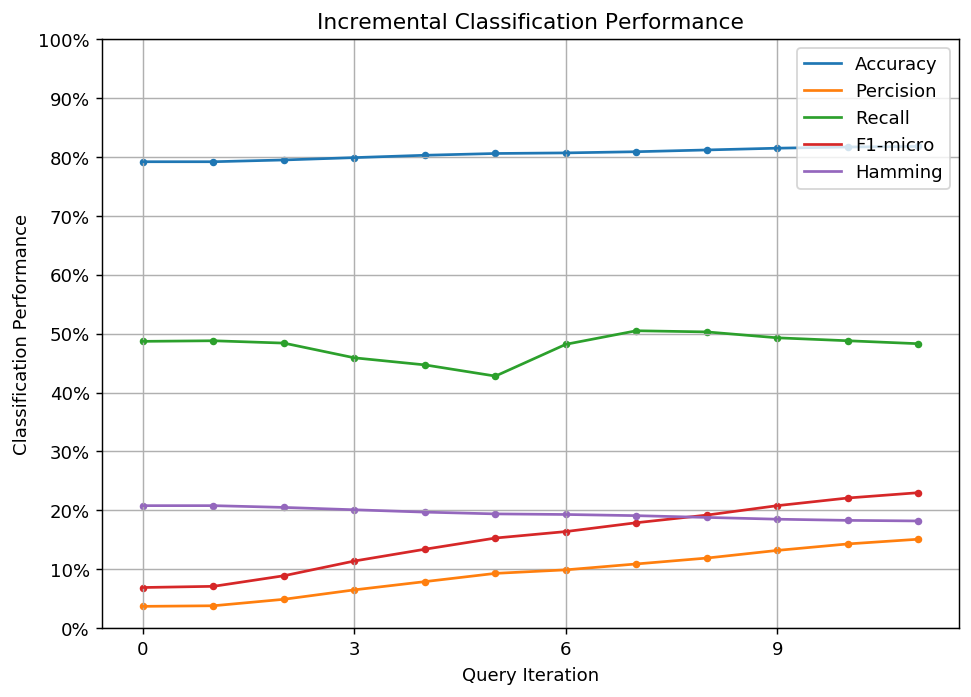

In [13]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(accuracy_res_R)
ax.plot(precision_res_R)
ax.plot(recall_res_R)
ax.plot(f1_res_R)
ax.plot(hamming_loss_res_R)
ax.scatter(range(len(accuracy_res_R)), accuracy_res_R, s=10)
ax.scatter(range(len(precision_res_R)), precision_res_R, s=10)
ax.scatter(range(len(recall_res_R)), recall_res_R, s=10)
ax.scatter(range(len(f1_res_R)), f1_res_R, s=10)
ax.scatter(range(len(hamming_loss_res_R)), hamming_loss_res_R, s=10)
ax.legend(['Accuracy','Percision','Recall','F1-micro','Hamming'])


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental Classification Performance')
ax.set_xlabel('Query Iteration')
ax.set_ylabel('Classification Performance')

plt.show()

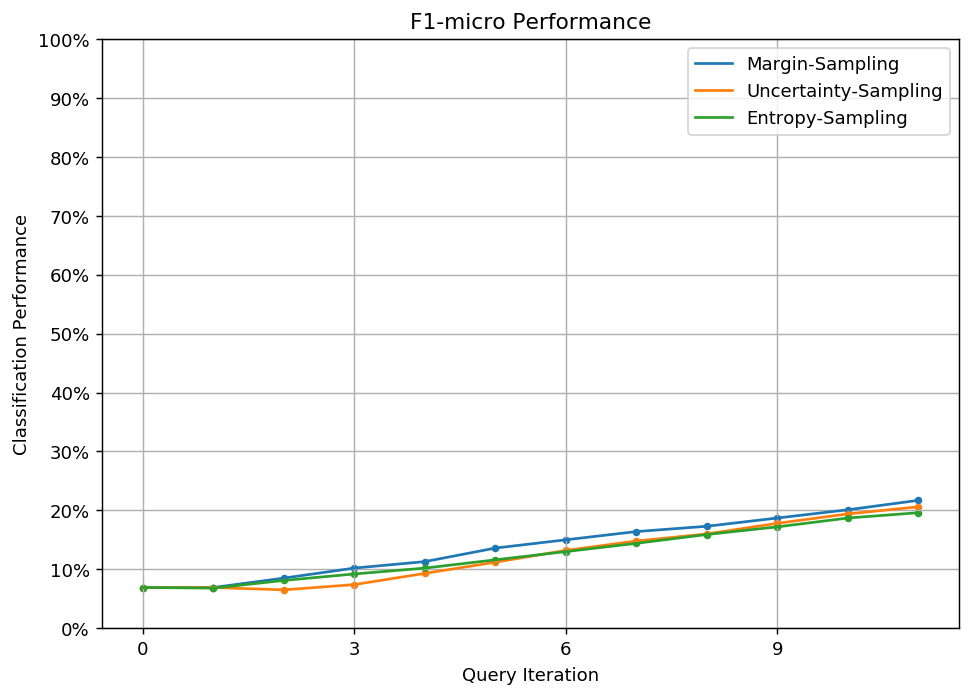

In [14]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(f1_res)
ax.plot(f1_res_U)
ax.plot(f1_res_E)


ax.scatter(range(len(f1_res)), f1_res, s=10)
ax.scatter(range(len(f1_res_U)), f1_res_U, s=10)
ax.scatter(range(len(f1_res_E)), f1_res_E, s=10)


ax.legend(['Margin-Sampling','Uncertainty-Sampling','Entropy-Sampling'])


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('F1-micro Performance')
ax.set_xlabel('Query Iteration')
ax.set_ylabel('Classification Performance')

plt.show()

In [ ]:
# Split in actual train and holdout set
x_train_actual, x_holdout, y_train_actual, y_holdout = train_test_split(x_train, y_train, test_size=0.9, random_state=42)

print(x_train_actual.shape, y_train_actual.shape, x_holdout.shape, y_holdout.shape)


learner = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy= uncertainty_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 

# Record our learner's score on the raw data.
y_pred = learner.predict(x_test)

starting_res = multilabel_evaluation(y_pred, y_test)
print(starting_res)

accuracy_res_U2 = [starting_res["accuracy"]]
precision_res_U2 = [starting_res["precision"]]
recall_res_U2 = [starting_res["recall"]]
f1_res_U2 = [starting_res["f1_score"]]
hamming_loss_res_U2 = [starting_res["hamming_loss"]]

print("")
print("Starting Active Learning...")
print("")
start = datetime.now()

N_QUERIES = 6000
for index in range(N_QUERIES):
   query_index, query_instance = learner.query(x_holdout)
   # Teach our ActiveLearner model the record it has requested.
   X, y = x_holdout[query_index].reshape(1, -1), y_holdout[query_index].reshape(1, -1)
   learner.teach(X=X, y=y)
   
   # Remove the queried instance from the unlabeled pool.
   x_holdout, y_holdout = np.delete(x_holdout, query_index, axis=0), np.delete(y_holdout, query_index, axis=0)
   
   print(index)
   if(index % 100) == 0:      
      prediction = learner.predict(x_test)
      results = multilabel_evaluation(prediction, y_test)
      print(results)
    
      accuracy_res_U2.append(results["accuracy"])
      precision_res_U2.append(results["precision"])
      recall_res_U2.append(results["recall"])
      f1_res_U2.append(results["f1_score"])
      hamming_loss_res_U2.append(results["hamming_loss"])

        
prediction = learner.predict(x_test)
results = multilabel_evaluation(prediction, y_test)
print(results)
    
accuracy_res_U2.append(results["accuracy"])
precision_res_U2.append(results["precision"])
recall_res_U2.append(results["recall"])
f1_res_U2.append(results["f1_score"])
hamming_loss_res_U2.append(results["hamming_loss"])      
            
print('Finished active learning in : ', datetime.now()-start)

(683, 4824) (683, 11) (6155, 4824) (6155, 11)
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.487, 'f1_score': 0.069, 'hamming_loss': 0.208}

Starting Active Learning...

0
{'accuracy': 0.792, 'precision': 0.037, 'recall': 0.487, 'f1_score': 0.069, 'hamming_loss': 0.208}
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
{'accuracy': 0.791, 'precision': 0.035, 'recall': 0.477, 'f1_score': 0.065, 'hamming_loss': 0.209}
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
1

In [ ]:
# Split in actual train and holdout set
x_train_actual, x_holdout, y_train_actual, y_holdout = train_test_split(x_train, y_train, test_size=0.9, random_state=42)

print(x_train_actual.shape, y_train_actual.shape, x_holdout.shape, y_holdout.shape)


learner = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy= uncertainty_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 

# Record our learner's score on the raw data.
y_pred = learner.predict(x_test)

starting_res = multilabel_evaluation(y_pred, y_test)
print(starting_res)

accuracy_res_RA = [starting_res["accuracy"]]
precision_res_RA = [starting_res["precision"]]
recall_res_RA = [starting_res["recall"]]
f1_res_RA = [starting_res["f1_score"]]
hamming_loss_res_RA = [starting_res["hamming_loss"]]

print("")
print("Starting Active Learning...")
print("")
start = datetime.now()

N_QUERIES = 6000
for index in range(N_QUERIES):
   
   if(index % 500) == 0:
      ########################################################  
      n_labeled_examples = x_holdout.shape[0]
      training_indices = np.random.randint(low=0, high=n_labeled_examples , size=400)
      

      x_train_actual = np.concatenate((x_train_actual,  x_holdout[training_indices]), axis=0)
      y_train_actual = np.concatenate((y_train_actual, y_holdout[training_indices]), axis=0) 

      x_holdout = np.delete(x_holdout, training_indices, axis=0)
      y_holdout = np.delete(y_holdout, training_indices, axis=0)
      ########################################################  
      print(index)  
      learner = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy= uncertainty_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 
    
      prediction = learner.predict(x_test)
      results = multilabel_evaluation(prediction, y_test)
      print(results)
    
      accuracy_res_RA.append(results["accuracy"])
      precision_res_RA.append(results["precision"])
      recall_res_RA.append(results["recall"])
      f1_res_RA.append(results["f1_score"])
      hamming_loss_res_RA.append(results["hamming_loss"])


learner = ActiveLearner(estimator=OneVsRestClassifier(BernoulliNB(class_prior=None, alpha=.7)),
                                     query_strategy= uncertainty_sampling,
                                     X_training=x_train_actual, y_training=y_train_actual) 
prediction = learner.predict(x_test)
results = multilabel_evaluation(prediction, y_test)
print(results)
    
accuracy_res_RA.append(results["accuracy"])
precision_res_RA.append(results["precision"])
recall_res_RA.append(results["recall"])
f1_res_RA.append(results["f1_score"])
hamming_loss_res_RA.append(results["hamming_loss"])      
            
print('Finished active learning in : ', datetime.now()-start)


f1_res_RA = f1_res_RA[:len(f1_res_RA)-1]

f1_res_U_red = []
for i in range(len(f1_res_U2)):
    if(i%4 == 0 and i not in [4,8,12]):
        f1_res_U_red.append(f1_res_U2[i])

In [ ]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(f1_res_U_red)
ax.plot(f1_res_RA)

ax.scatter(range(len(f1_res_U_red)), f1_res_U_red, s=10)
ax.scatter(range(len(f1_res_RA)), f1_res_RA, s=10)

ax.legend(['Uncertainty-Sampling','Random-Sampling'])


ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('F1-macro AL VS Random')
ax.set_xlabel('Query Iteration')
ax.set_ylabel('Classification Performance')

plt.show()